<a href="https://colab.research.google.com/github/danielbauer1979/ML_656/blob/main/Assignment8_Sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analyzing Wine Data via Cluster and PCA

(by courtesy of Hao Tran)

As we revert back to the wine dataset, we are not concerned about understanding the types of wines there are out there. Before, we tried to predict the quality of the wine based on the other features. This time, we are trying to understand the relationships between each of the variables. To tackle this issue, we will use k-means clustering to group the wines and use principal component analysis to reduce a highly-dimensional dataset.

##Data Preparation and Cleaning

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
!git clone https://github.com/danielbauer1979/ML_656.git

Cloning into 'ML_656'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 114 (delta 50), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (114/114), 21.73 MiB | 3.27 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [3]:
wine = pd.read_csv('ML_656/winequality-red.csv', sep = ';')

In [4]:
wine.describe

<bound method NDFrame.describe of       fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
0               7.4             0.700         0.00  ...       0.56      9.4        5
1               7.8             0.880         0.00  ...       0.68      9.8        5
2               7.8             0.760         0.04  ...       0.65      9.8        5
3              11.2             0.280         0.56  ...       0.58      9.8        6
4               7.4             0.700         0.00  ...       0.56      9.4        5
...             ...               ...          ...  ...        ...      ...      ...
1594            6.2             0.600         0.08  ...       0.58     10.5        5
1595            5.9             0.550         0.10  ...       0.76     11.2        6
1596            6.3             0.510         0.13  ...       0.75     11.0        6
1597            5.9             0.645         0.12  ...       0.71     10.2        5
1598            6.0            

In [5]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


For clustering, we need to scale each variable (as long as it's continuous data). That is, we need to make sure each variable is relatable to one another. We cannot compare 1 meter to 1 mile. That concept applies to this dataset. Since clustering focuses on minimizing the distance between data points, we cannot have them on separate scales such as pH and wine quality. 

In [6]:
scaler = MinMaxScaler()
scaler.fit(wine)
wine_sc_0 = scaler.transform(wine)
wine_sc = pd.DataFrame(data = wine_sc_0, columns = wine.columns)
wine_sc.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,0.4
1,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385,0.4
2,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385,0.4
3,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385,0.6
4,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,0.4


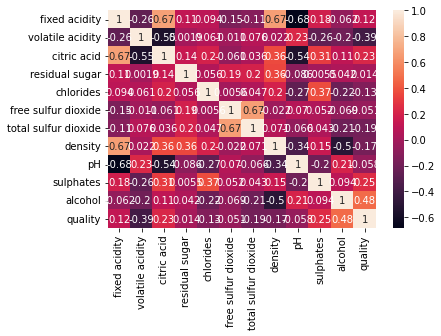

In [7]:
sns.heatmap(wine_sc.corr(), annot = True)

##K-Means Clustering
For K-Means clustering, we choose the number of cluster centers (AKA wine types) and the model will automatically assign each wine to their group. THe way this model works is by choosing a data point as the "center" and picking data points closest to the center. The model will change centers until it realizes that it doesn't need to change centers anymore. That will be the "final center". We aren't sure about how many cluster centers we want so we can use a bar graph to evaluate this.

This graph explains the total distance between each datapoint and its center. With only 1 center point, we see a very high sum of squared distance. We can't choose a bunch of centers, since this leads to overfitting. Each data point would be its own cluster center if we went this route. According to the graph, we seem to be okay with choosing 5 since the total distance doesn't drastically reduce after 5 centers.

<function matplotlib.pyplot.show>

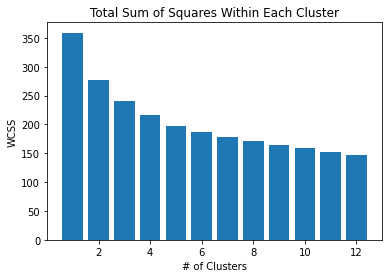

In [8]:
plt.figure(figsize = (6,4))
wcss = []
for i in range(1,13):
  kmeans = KMeans(n_clusters= i, init = 'k-means++', max_iter = 1000, n_init = 10, random_state = 123)
  kmeans.fit(wine_sc)
  wcss.append(kmeans.inertia_)
plt.bar(range(1,13), wcss)
plt.title('Total Sum of Squares Within Each Cluster')
plt.xlabel('# of Clusters')
plt.ylabel('WCSS')
plt.show

In [9]:
#Initialize model and fit the wine data
kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 1000, random_state = 123)
kmeans.fit(wine_sc)
centroids = kmeans.cluster_centers_
#centroids

The array of values above indicates the coordinates for the cluster center. For example, the 1st cluster center's 1st number indicates the coordinate for the "fixed acidity" variable and so on. Let's predict each wine's cluster center and visualize it. 

In [10]:
label = kmeans.fit_predict(wine_sc)
label

array([4, 4, 4, ..., 1, 1, 2], dtype=int32)

In [11]:
#All rows of the wine data that belong to the 1st cluster center/centroid
filtered_label0 = wine_sc[label == 0]
filtered_label0.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
9,0.256637,0.260274,0.36,0.356164,0.098497,0.225352,0.339223,0.567548,0.480315,0.281437,0.323077,0.4
11,0.256637,0.260274,0.36,0.356164,0.098497,0.225352,0.339223,0.567548,0.480315,0.281437,0.323077,0.4
14,0.380531,0.342466,0.18,0.198630,0.273790,0.718310,0.491166,0.626285,0.330709,0.329341,0.123077,0.4


The black dots indicate the centroid, while each color pertains to their own cluster. Based on the model we selected, it seems a little bit clobbered up. However, that is the point of K-means clustering. If it was obvious, we wouldn't need to run a machine learning model and just simply circle the groups by hand. Keep in mind we ran this model according to all 12 features. That implies a lot of variance and directions for our clustering algorithm to work with. Let's apply principal component analysis to reduce this dimensionality and make it easier for our algorithm to classify the wine data.

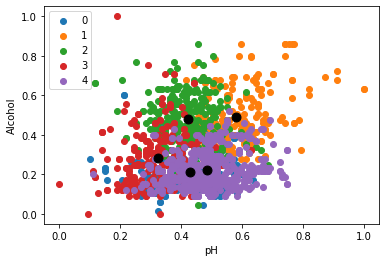

In [12]:
plt.figure(figsize = (6,4))
num_clusters = np.unique(label)
for i in num_clusters:
  plt.scatter(wine_sc.iloc[label == i, 8], wine_sc.iloc[label ==i, 10], label = i)
plt.scatter(centroids[:,8], centroids[:,10], s = 80, color = 'black')
plt.xlabel('pH')
plt.ylabel('Alcohol')
plt.legend()
plt.show()

##Principal Component Analysis
Recall that we had to work with 12 features. This is a high-dimensional space, and helps reduce the noise for our algorithm for clustering. The principal components aid in accounting for the variance that occurs within our dataset.

We want to choose the number of principal components that accounts for a lot of variation without going too high. Otherwise, we're back at 12 features. The cumulative sum of 4 principal components seem to account for about 80% of our variation, which I would say is good enough.

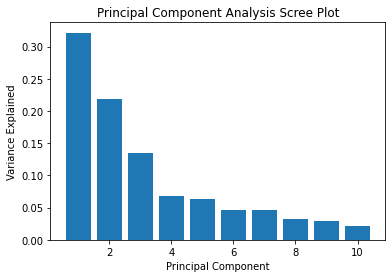

In [13]:
plt.figure(figsize=(6,4))
pca = PCA(n_components=10)
pca_fit = pca.fit(wine_sc)
pc_values = np.arange(pca_fit.n_components_) + 1
plt.bar(pc_values, pca.explained_variance_ratio_)
plt.title('Principal Component Analysis Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [14]:
pca = PCA(n_components = 4)
principalComponents = pca.fit_transform(wine_sc)
pcDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2','PC3','PC4'])
pcDF.head(2)

,PC1,PC2,PC3,PC4
0,-0.308010,-0.198750,-0.157373,0.083623
1,-0.265056,-0.237308,0.057130,0.098049


With this "new dataset", we can apply our Kmeans algorithm to see if our wine clustering looks more clean and appropriate.

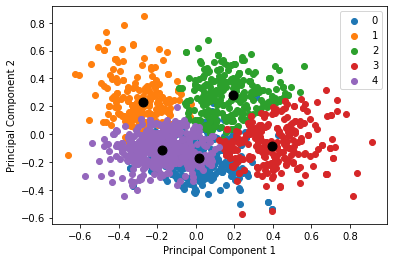

In [15]:
plt.figure(figsize = (6,4))
kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 1000, random_state = 123)
label_pca = kmeans.fit_predict(pcDF)
num_clusters_pca = np.unique(label_pca)
centroids = kmeans.cluster_centers_
for i in num_clusters_pca:
  plt.scatter(pcDF.iloc[label == i, 0],pcDF.iloc[label == i, 1], label = i)
plt.scatter(centroids[:,0], centroids[:,1], s = 80, color = 'black')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Having our clustering algorithm work with the PC dataset definitely makes our graph look easier to distinguish which datapoint belongs to which cluster.

##Conclusion
It seems that our clustering algorithm can work with either 4 or 5 clusters. We see the blue and purple datapoints overlap one another, so 4 would have worked. Considering that we have about 1600 rows, I thought it would be a better idea to increase to 5 clusters for interpetability. The yellow, green, and red data points are easily distinguishable from each other. This gives an additional perspective on our wine data. Recall that we tried to predict wine quality based on the other features. This time, we can understand the relationship between one another, so our leadership team can make some interpretations for each feature of the wine. In our principal component analysis, we find that 4 factors are good enough to explain the variation of the data. This allows us to work with only 4 columns instead of 12, reducing the high-dimensionality that makes it difficult for an algorithm to calculate. 